## Overview
Dataset has many features, but we need `utterance` (phrase), `frame` (took middle frame from video) and `emotion` (can be one of

 ```['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']```).
 
Data was already split on 3 types `train`, `test` and `dev`. I assume that `dev` is for validation... 

Our dataset ouputs this three features: `utterance`, `frame` and `emotion`. We preprocess `utterance` with clip tokenizer and `frame` with clip image preprocessing. `emotion` can be preprocessed in two ways based on task. For classification we encode each `emotion` with ordinal encoding. For other tasks `emotion` is tokenized in the same way as utterance (clip tokenizer).


In [1]:
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import warnings
import clip
import torch
from torch import nn
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel, DataCollatorWithPadding
from tqdm import tqdm
warnings.filterwarnings('ignore')

/home/tohchukovda/.conda/envs/rockstar/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:3" if torch.cuda.is_available() else "cpu"
# device = "cpu"
device

'cuda:3'

In [3]:
class MeldDatasetProcessor(Dataset):
    SPLITS = ['train', 'dev', 'test']
    EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

    def __init__(self, dataset_path, split, encode_emotion=True, image_transform=None, text_transform=None):

        self.split = split
        self.image_transform = image_transform
        self.text_transform = text_transform
        self.images_dir = os.path.join(dataset_path, split)
        self.mapping = pd.read_csv(os.path.join(dataset_path, f"{split}.csv"))
        self.emotion_encoder = self._initialize_emotion_encoder()
        self.encode_emotion = encode_emotion

    def __len__(self):
        return len(self.mapping)

    def __getitem__(self, idx):
        item_data = self.mapping.iloc[idx]
        image_name = item_data["Image_Name"] 
        image = self._process_image(image_name)

        if self.encode_emotion:
            emotion = self.emotion_encoder.transform([item_data["Emotion"]])[0]
        else:
            emotion = self._process_text(f"A photo of a {item_data["Emotion"]} human")

        return {
            'frame': image,
            'utterance': self._process_text(item_data["Utterance"]),
            'emotion': emotion
        }

    def _initialize_emotion_encoder(self):
        encoder = LabelEncoder()
        return encoder.fit(self.EMOTIONS)

    def _process_image(self, image_name):
        image = Image.open(os.path.join(self.images_dir, image_name))
        if self.image_transform:
            image = self.image_transform(image)
    
        return image

    def _process_text(self, text):        
        if self.text_transform:
            text = self.text_transform(text)
    
        return text

    @classmethod
    def create_dataloaders(cls, dataset_kwargs, dataloader_kwargs):
            datasets = {
                split: cls(**dataset_kwargs, split=split)
                for split in cls.SPLITS
            }

            dataloaders = {
                split: DataLoader(
                    dataset,
                    shuffle=(split == 'train'),
                    pin_memory=True,
                    **dataloader_kwargs
                )
                for split, dataset in datasets.items()
            }

            return (
                dataloaders['train'],
                dataloaders['dev'],
                dataloaders['test'],
                datasets['train'].emotion_encoder
            )

In [4]:
# model, preprocess = clip.load("ViT-B/32", device=device)
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", device_map = device)
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

model, processor = clip.load("ViT-B/32", device=device)
model = model.float()

## Emotions -> categorical (for first task with classification)

In [5]:
dataset_kwargs = dict(
    dataset_path="MELD.Preprocessed",
    text_transform = lambda x: clip.tokenize(x, truncate=True),
    encode_emotion=True,
    image_transform = processor,
)

dataloader_kwargs = dict(
    batch_size=32,
    # num_workers=4
    # collate_fn=DataCollatorWithPadding(tokenizer=processor.tokenizer, padding=True)
)

train_loader, val_loader, test_loader, label_encoder = (
    MeldDatasetProcessor.create_dataloaders(
        dataset_kwargs = dataset_kwargs,
        dataloader_kwargs = dataloader_kwargs
    )
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

batch = next(iter(train_loader))

Number of training batches: 313
Number of validation batches: 35
Number of test batches: 82


# Train CLIP with contrastive loss

In [6]:
for param in model.transformer.parameters():
    param.requires_grad = False

In [7]:
epochs = 10
optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-5)
criterion = torch.nn.CrossEntropyLoss()

scheduler = OneCycleLR(optimizer, max_lr=5e-5, pct_start=0.1, anneal_strategy='linear', steps_per_epoch=len(train_loader), epochs=epochs)

In [8]:
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, logits_per_image, logits_per_text):
        labels = torch.arange(logits_per_image.size(0), device=logits_per_image.device)
        loss_img = self.criterion(logits_per_image, labels)
        loss_txt = self.criterion(logits_per_text, labels)
        return (loss_img + loss_txt) / 2

In [9]:
train_losses = []
loss_fn = ContrastiveLoss()
# Training loop
model.train()
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for idx_batch, batch in tqdm(enumerate(train_loader)):
        # input_ids = batch["input_ids"].to(device)
        # pixel_values = batch["pixel_values"].to(device)
        frame = batch["frame"].to(device)
        utterance = batch["utterance"].squeeze(1).to(device)

        # Forward pass
        # outputs = model(input_ids=input_ids, pixel_values=pixel_values)
        logits_per_image, logits_per_text = model(frame, utterance)

        # logits_per_image = outputs.logits_per_image
        # logits_per_text = outputs.logits_per_text

        loss = loss_fn(logits_per_image, logits_per_text)

        if idx_batch % 20 == 0:
            print(f"epoch: {epoch + 1}, batch_idx: {idx_batch}, loss: {loss.item():.4f}")
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1, batch_idx: 0, loss: 5.5776


epoch: 1, batch_idx: 20, loss: 3.6667


epoch: 1, batch_idx: 40, loss: 3.3658


epoch: 1, batch_idx: 60, loss: 3.5496


epoch: 1, batch_idx: 80, loss: 3.1714


epoch: 1, batch_idx: 100, loss: 3.3979


epoch: 1, batch_idx: 120, loss: 3.2872


epoch: 1, batch_idx: 140, loss: 3.2119


epoch: 1, batch_idx: 160, loss: 3.2907


epoch: 1, batch_idx: 180, loss: 3.4335


epoch: 1, batch_idx: 200, loss: 3.2501


epoch: 1, batch_idx: 220, loss: 3.3395


epoch: 1, batch_idx: 240, loss: 3.0709


epoch: 1, batch_idx: 260, loss: 3.3542


epoch: 1, batch_idx: 280, loss: 3.2920


epoch: 1, batch_idx: 300, loss: 3.4055


313it [03:51,  1.35it/s]
 10%|█         | 1/10 [03:51<34:43, 231.50s/it]

Epoch 1/10, Loss: 3.4176


epoch: 2, batch_idx: 0, loss: 3.1036


epoch: 2, batch_idx: 20, loss: 3.3516


epoch: 2, batch_idx: 40, loss: 3.0830


epoch: 2, batch_idx: 60, loss: 3.0167


epoch: 2, batch_idx: 80, loss: 3.0554


epoch: 2, batch_idx: 100, loss: 2.9307


epoch: 2, batch_idx: 120, loss: 3.0519


epoch: 2, batch_idx: 140, loss: 3.2046


epoch: 2, batch_idx: 160, loss: 3.3665


epoch: 2, batch_idx: 180, loss: 3.2775


epoch: 2, batch_idx: 200, loss: 2.9955


epoch: 2, batch_idx: 220, loss: 3.0710


epoch: 2, batch_idx: 240, loss: 2.8582


epoch: 2, batch_idx: 260, loss: 2.8125


epoch: 2, batch_idx: 280, loss: 3.3888


epoch: 2, batch_idx: 300, loss: 3.3367


313it [03:50,  1.36it/s]
 20%|██        | 2/10 [07:41<30:45, 230.65s/it]

Epoch 2/10, Loss: 3.0903


epoch: 3, batch_idx: 0, loss: 2.0768


epoch: 3, batch_idx: 20, loss: 1.7731


epoch: 3, batch_idx: 40, loss: 1.9028


epoch: 3, batch_idx: 60, loss: 2.2183


epoch: 3, batch_idx: 80, loss: 2.4306


epoch: 3, batch_idx: 100, loss: 2.4067


epoch: 3, batch_idx: 120, loss: 1.8611


epoch: 3, batch_idx: 140, loss: 2.3970


epoch: 3, batch_idx: 160, loss: 2.2020


epoch: 3, batch_idx: 180, loss: 2.5228


epoch: 3, batch_idx: 200, loss: 2.2371


epoch: 3, batch_idx: 220, loss: 2.5820


epoch: 3, batch_idx: 240, loss: 1.9357


epoch: 3, batch_idx: 260, loss: 2.4764


epoch: 3, batch_idx: 280, loss: 2.2640


epoch: 3, batch_idx: 300, loss: 2.1154


313it [03:54,  1.33it/s]
 30%|███       | 3/10 [11:36<27:06, 232.42s/it]

Epoch 3/10, Loss: 2.3083


epoch: 4, batch_idx: 0, loss: 1.0288


epoch: 4, batch_idx: 20, loss: 0.9096


epoch: 4, batch_idx: 40, loss: 0.8490


epoch: 4, batch_idx: 60, loss: 0.9887


epoch: 4, batch_idx: 80, loss: 0.8918


epoch: 4, batch_idx: 100, loss: 0.8873


epoch: 4, batch_idx: 120, loss: 1.0055


epoch: 4, batch_idx: 140, loss: 1.0462


epoch: 4, batch_idx: 160, loss: 0.8827


epoch: 4, batch_idx: 180, loss: 1.2521


epoch: 4, batch_idx: 200, loss: 1.1512


epoch: 4, batch_idx: 220, loss: 0.8624


epoch: 4, batch_idx: 240, loss: 1.6760


epoch: 4, batch_idx: 260, loss: 1.2871


epoch: 4, batch_idx: 280, loss: 1.0660


epoch: 4, batch_idx: 300, loss: 1.4868


313it [03:50,  1.36it/s]
 40%|████      | 4/10 [15:26<23:08, 231.49s/it]

Epoch 4/10, Loss: 1.1221


epoch: 5, batch_idx: 0, loss: 0.4251


epoch: 5, batch_idx: 20, loss: 0.1646


epoch: 5, batch_idx: 40, loss: 0.3330


epoch: 5, batch_idx: 60, loss: 0.2835


epoch: 5, batch_idx: 80, loss: 0.3149


epoch: 5, batch_idx: 100, loss: 0.2267


epoch: 5, batch_idx: 120, loss: 0.1124


epoch: 5, batch_idx: 140, loss: 0.2471


epoch: 5, batch_idx: 160, loss: 0.1105


epoch: 5, batch_idx: 180, loss: 0.2786


epoch: 5, batch_idx: 200, loss: 0.1058


epoch: 5, batch_idx: 220, loss: 0.2523


epoch: 5, batch_idx: 240, loss: 0.3130


epoch: 5, batch_idx: 260, loss: 0.3803


epoch: 5, batch_idx: 280, loss: 0.1812


epoch: 5, batch_idx: 300, loss: 0.2585


313it [03:56,  1.33it/s]
 50%|█████     | 5/10 [19:22<19:25, 233.15s/it]

Epoch 5/10, Loss: 0.2928


epoch: 6, batch_idx: 0, loss: 0.0989


epoch: 6, batch_idx: 20, loss: 0.2834


epoch: 6, batch_idx: 40, loss: 0.0883


epoch: 6, batch_idx: 60, loss: 0.1709


epoch: 6, batch_idx: 80, loss: 0.1293


epoch: 6, batch_idx: 100, loss: 0.0245


epoch: 6, batch_idx: 120, loss: 0.0560


epoch: 6, batch_idx: 140, loss: 0.0248


epoch: 6, batch_idx: 160, loss: 0.0456


epoch: 6, batch_idx: 180, loss: 0.1205


epoch: 6, batch_idx: 200, loss: 0.1554


epoch: 6, batch_idx: 220, loss: 0.0501


epoch: 6, batch_idx: 240, loss: 0.0582


epoch: 6, batch_idx: 260, loss: 0.1112


epoch: 6, batch_idx: 280, loss: 0.0318


epoch: 6, batch_idx: 300, loss: 0.0624


313it [03:48,  1.37it/s]
 60%|██████    | 6/10 [23:10<15:26, 231.57s/it]

Epoch 6/10, Loss: 0.0965


epoch: 7, batch_idx: 0, loss: 0.0162


epoch: 7, batch_idx: 20, loss: 0.0858


epoch: 7, batch_idx: 40, loss: 0.0610


epoch: 7, batch_idx: 60, loss: 0.0963


epoch: 7, batch_idx: 80, loss: 0.0534


epoch: 7, batch_idx: 100, loss: 0.0307


epoch: 7, batch_idx: 120, loss: 0.0320


epoch: 7, batch_idx: 140, loss: 0.0586


epoch: 7, batch_idx: 160, loss: 0.0290


epoch: 7, batch_idx: 180, loss: 0.0450


epoch: 7, batch_idx: 200, loss: 0.0186


epoch: 7, batch_idx: 220, loss: 0.0833


epoch: 7, batch_idx: 240, loss: 0.0407


epoch: 7, batch_idx: 260, loss: 0.0064


epoch: 7, batch_idx: 280, loss: 0.1519


epoch: 7, batch_idx: 300, loss: 0.1449


313it [03:51,  1.35it/s]
 70%|███████   | 7/10 [27:02<11:34, 231.50s/it]

Epoch 7/10, Loss: 0.0450


epoch: 8, batch_idx: 0, loss: 0.0148


epoch: 8, batch_idx: 20, loss: 0.0920


epoch: 8, batch_idx: 40, loss: 0.0119


epoch: 8, batch_idx: 60, loss: 0.0078


epoch: 8, batch_idx: 80, loss: 0.0100


epoch: 8, batch_idx: 100, loss: 0.0517


epoch: 8, batch_idx: 120, loss: 0.0521


epoch: 8, batch_idx: 140, loss: 0.0278


epoch: 8, batch_idx: 160, loss: 0.0076


epoch: 8, batch_idx: 180, loss: 0.0079


epoch: 8, batch_idx: 200, loss: 0.0051


epoch: 8, batch_idx: 220, loss: 0.0057


epoch: 8, batch_idx: 240, loss: 0.0071


epoch: 8, batch_idx: 260, loss: 0.0080


epoch: 8, batch_idx: 280, loss: 0.0080


epoch: 8, batch_idx: 300, loss: 0.0036


313it [03:49,  1.36it/s]
 80%|████████  | 8/10 [30:51<07:41, 230.89s/it]

Epoch 8/10, Loss: 0.0317


epoch: 9, batch_idx: 0, loss: 0.0058


epoch: 9, batch_idx: 20, loss: 0.0190


epoch: 9, batch_idx: 40, loss: 0.0036


epoch: 9, batch_idx: 60, loss: 0.0031


epoch: 9, batch_idx: 80, loss: 0.0054


epoch: 9, batch_idx: 100, loss: 0.0077


epoch: 9, batch_idx: 120, loss: 0.0172


epoch: 9, batch_idx: 140, loss: 0.0699


epoch: 9, batch_idx: 160, loss: 0.0033


epoch: 9, batch_idx: 180, loss: 0.0075


epoch: 9, batch_idx: 200, loss: 0.0023


epoch: 9, batch_idx: 220, loss: 0.0523


epoch: 9, batch_idx: 240, loss: 0.0015


epoch: 9, batch_idx: 260, loss: 0.0037


epoch: 9, batch_idx: 280, loss: 0.0028


epoch: 9, batch_idx: 300, loss: 0.0030


313it [03:45,  1.39it/s]
 90%|█████████ | 9/10 [34:37<03:49, 229.32s/it]

Epoch 9/10, Loss: 0.0237


epoch: 10, batch_idx: 0, loss: 0.0028


epoch: 10, batch_idx: 20, loss: 0.0061


epoch: 10, batch_idx: 40, loss: 0.0046


epoch: 10, batch_idx: 60, loss: 0.0053


epoch: 10, batch_idx: 80, loss: 0.0117


epoch: 10, batch_idx: 100, loss: 0.0046


epoch: 10, batch_idx: 120, loss: 0.0022


epoch: 10, batch_idx: 140, loss: 0.0106


epoch: 10, batch_idx: 160, loss: 0.0898


epoch: 10, batch_idx: 180, loss: 0.0012


epoch: 10, batch_idx: 200, loss: 0.0065


epoch: 10, batch_idx: 220, loss: 0.0150


epoch: 10, batch_idx: 240, loss: 0.0023


epoch: 10, batch_idx: 260, loss: 0.0024


epoch: 10, batch_idx: 280, loss: 0.1288


epoch: 10, batch_idx: 300, loss: 0.0526


313it [03:47,  1.38it/s]
100%|██████████| 10/10 [38:25<00:00, 230.50s/it]

Epoch 10/10, Loss: 0.0156


In [10]:
# model.save_pretrained('clip_trained_on_meld_4_epoches')
# processor.save_pretrained('clip_trained_on_meld_4_epoches')

In [11]:
import os
os.mkdir("./clip_trained_on_meld_10_epoches")
torch.save(model, './clip_trained_on_meld_10_epoches/model')

In [35]:
model.visual_projection.weight.shape[0]

512

In [38]:
model.text_projection.weight.shape[0]

512

In [7]:
dataset_kwargs["encode_emotion"] = False

train_loader, val_loader, test_loader, label_encoder = (
    MeldDatasetProcessor.create_dataloaders(
        dataset_kwargs = dataset_kwargs,
        dataloader_kwargs = dataloader_kwargs
    )
)

batch = next(iter(train_loader))
frames = batch['frame']
utterances = batch['utterance']
emotions = batch['emotion']

In [8]:
print(f"Batch shapes: Frames {frames.shape}, Emotions {emotions.shape}, Utterances {utterances.shape}")

Batch shapes: Frames torch.Size([32, 3, 224, 224]), Emotions torch.Size([32, 1, 77]), Utterances torch.Size([32, 1, 77])


In [9]:
dataset = MeldDatasetProcessor("MELD.Preprocessed", "train", encode_emotion=False)

In [10]:
item =  dataset[298]
item

{'frame': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720>,
 'utterance': "They've only been going out for a few weeks and Phoebe is completely hung up on Mike!",
 'emotion': 'anger'}

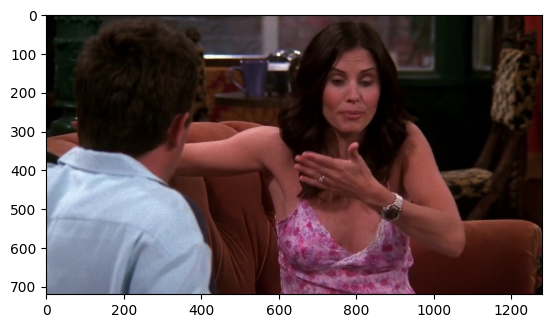

In [11]:
plt.imshow(item['frame'])